In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Input, Model, regularizers
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
from collections import Counter


In [25]:
print("TensorFlow version:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())

TensorFlow version: 2.16.2
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [26]:
base_dir = "./pest"   
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

In [27]:
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

batch_size = 32

# Training Data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Validation Data
validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

#Test Data
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)



Found 2400 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


In [ ]:
base_model = MobileNetV2(
    input_shape=(150,150,3),
    include_top=False,
    weights='imagenet'
)

# So not to overwrite pre-trained weights
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(
    256, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(
    128, activation='relu',
    kernel_regularizer=regularizers.l2(1e-4)
)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

outputs = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

/var/folders/14/1czfbr_d68v0hl_7303c60nw0000gn/T/ipykernel_34512/352598340.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


In [33]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy']
)

#Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "best_mobilenet_pest_model.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)
#model.summary()

In [30]:
class_weights = None  
# labels = train_generator.classes
# class_weights = compute_class_weight(
#     'balanced',
#     classes=np.unique(labels),
#     y=labels
# )
# class_weights = dict(enumerate(class_weights))

/opt/anaconda3/envs/tfenv1/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.1348 - loss: 3.4788
Epoch 1: val_accuracy improved from None to 0.38000, saving model to best_mobilenet_pest_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.1688 - loss: 3.2137 - val_accuracy: 0.3800 - val_loss: 1.9600 - learning_rate: 1.0000e-04
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.2920 - loss: 2.5371
Epoch 2: val_accuracy improved from 0.38000 to 0.57500, saving model to best_mobilenet_pest_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.3088 - loss: 2.4383 - val_accuracy: 0.5750 - val_loss: 1.5589 - learning_rate: 1.0000e-04
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3961 - loss: 2.1730
Epoch 3: val_accuracy improved from 0.57500 to 0.63500, saving model to best_mobilenet_pest_model.keras
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 103ms/step - accuracy: 0.4246 - loss: 2.1092 - val_accuracy: 0.6350 - val_loss: 1.3866 - learning_rate: 1.0000e-04


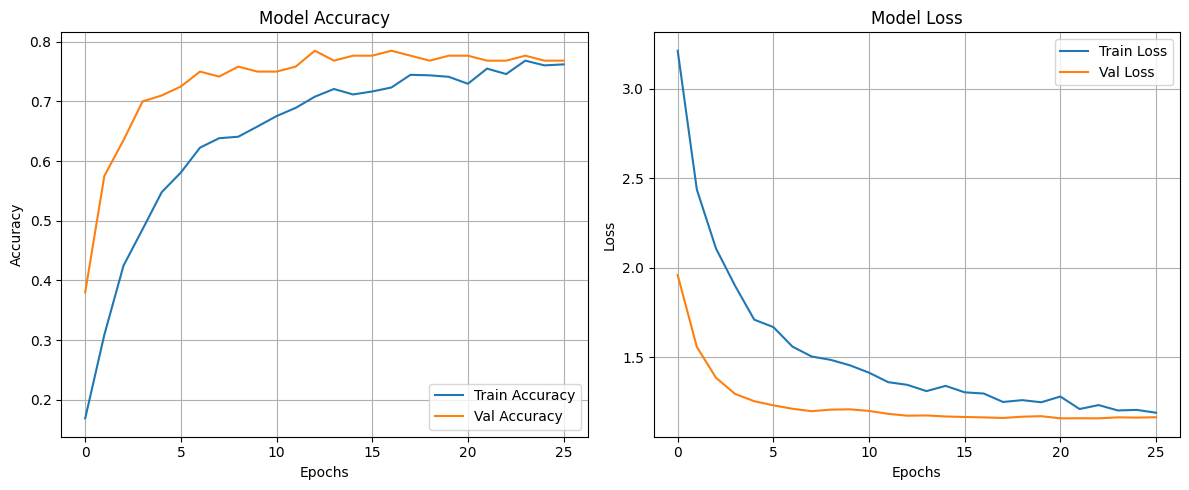

In [ ]:
# Training the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,          
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights  
)


# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [32]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\n Test accuracy: {test_acc * 100:.2f}%")

# Overfitting check
train_generator_eval = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False
)

train_loss, train_acc = model.evaluate(train_generator_eval)
print(f"Train accuracy: {train_acc * 100:.2f}%")
print(f"Validation accuracy: {history.history['val_accuracy'][-1] * 100:.2f}%")
print(f"Test accuracy: {test_acc * 100:.2f}%")

overfitting_gap = train_acc - test_acc
if overfitting_gap < 0.1:
    print(f" Generalized. Gap: {overfitting_gap * 100:.2f}%")
else:
    print(f"Overfitting. Gap: {overfitting_gap * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9050 - loss: 0.9026

 Test accuracy: 90.50%
Found 2400 images belonging to 10 classes.
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 74ms/step - accuracy: 0.9117 - loss: 0.8722
Train accuracy: 91.17%
Validation accuracy: 76.83%
Test accuracy: 90.50%
 Generalized. Gap: 0.67%
